In [ ]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import numpy as np
import jax
import aeon
import torch
import torch.nn as nn
import torch.functional as F
from sklearn.linear_model import RidgeCV

from utils.utils import print_name, print_shape
np.set_printoptions(precision=3, threshold=5) # Print options

In [7]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable

import torch
from torch import Tensor


def _ridge_LOOCV_d_leq_n_HAT(
        X: Tensor,
        y: Tensor,
        alphas: List[float]
    ) -> Tuple[Tensor, float]:
    """
    LOOCV for Ridge regression when D <= N using eigendecomposition.

    X shape (N, D)
    y shape (N, p)
    """
    # Convert alphas to tensor on the same device as X
    alphas = torch.tensor(alphas, device=X.device).unsqueeze(1)  # Shape (n_alphas, 1)

    # Perform eigendecomposition of the Gram matrix
    eigvals, eigvecs = torch.linalg.eigh(X.T @ X)  # eigvals: (D,), eigvecs: (D, D)

    # Project y onto the eigenspace
    XTy = X.T @ y  # Shape (D, p)
    eigvecs_T_XTy = eigvecs.T @ XTy  # Shape (D, p)

    # Prepare for broadcasting
    eigvals_exp = eigvals.unsqueeze(0).unsqueeze(-1)  # Shape (1, D, 1)
    eigvecs_T_XTy_exp = eigvecs_T_XTy.unsqueeze(0)  # Shape (1, D, p)

    # Compute denominators for all alphas
    denom = eigvals_exp + alphas.unsqueeze(-1)  # Shape (n_alphas, D, 1)

    # Compute alpha-scaled solutions for each output dimension
    beta_ridge = (eigvecs @ (eigvecs_T_XTy_exp / denom)).permute(1,0,2)  # Shape (D, n_alphas, p)
    
    # Compute predictions and residuals
    y_pred = torch.tensordot(X, beta_ridge, dims=1)  # Shape (N, n_alphas, p)
    residuals = y.unsqueeze(1) - y_pred  # Shape (N, n_alphas, p)

    # Compute hat matrix diagonals (same for all output dimensions)
    U = X @ eigvecs  # Shape (N, D)
    U_squared = U ** 2  # Shape (N, D)
    H_diag = (U_squared @ (1 / denom.squeeze(-1)).T)  # Shape (N, n_alphas)

    # Compute LOOCV errors across all dimensions
    errors = ((residuals / (1 - H_diag.unsqueeze(-1))) ** 2).mean(dim=(0, 2))  # Shape (n_alphas,)

    # Find the best alpha
    best_idx = errors.argmin()
    best_alpha = alphas[best_idx].item()
    beta_optimal = beta_ridge[:, best_idx, :]  # Shape (D, p)

    return beta_optimal, best_alpha



def _ridge_LOOCV_d_leq_n_PARALLEL(
        X: torch.Tensor,
        y: torch.Tensor,
        alphas: list
    ) -> tuple:
    """X shape (N, D), 
    y shape (N, p), 
    alphas shape (n_alphas,)."""
    # Convert alphas to tensor on the same device as X
    alphas_tensor = torch.tensor(alphas, device=X.device).unsqueeze(1)  # Shape (n_alphas, 1)

    # Perform SVD decomposition
    U, S, Vt = torch.linalg.svd(X, full_matrices=False)  # U: (N, D), S: (D,), Vt: (D, D)
    Ut_y = U.T @ y  # Shape (D, p)

    U_squared = U ** 2  # Shape (N, D)
    S_squared = S ** 2  # Shape (D,)

    # Prepare for broadcasting
    S_exp = S.unsqueeze(0)  # Shape (1, D)
    S_squared_exp = S_squared.unsqueeze(0)  # Shape (1, D)
    Ut_y_exp = Ut_y.unsqueeze(0)  # Shape (1, D, p)

    # Compute denominators and d for all alphas
    denom = S_squared_exp + alphas_tensor  # Shape (n_alphas, D)
    d = S_exp / denom  # Shape (n_alphas, D)

    # Compute beta_ridge for all alphas
    d_Ut_y = d.unsqueeze(2) * Ut_y_exp  # Shape (n_alphas, D, p)
    beta_ridge = (Vt.T.unsqueeze(0) @ d_Ut_y).permute(1, 0, 2)  # Shape (D, n_alphas, p)

    # Compute predictions and residuals
    y_pred = torch.tensordot(X, beta_ridge, dims=1) # Shape (N, n_alphas, p)
    residuals = y.unsqueeze(1) - y_pred  # Shape (N, n_alphas, p)

    # Compute hat matrix diagonals
    numerators = S_squared_exp / denom  # Shape (n_alphas, D)
    H_diag = (U_squared.unsqueeze(1) * numerators.unsqueeze(0)).sum(dim=2)  # Shape (N, n_alphas)

    # Compute LOOCV errors
    errors = ((residuals / (1 - H_diag.unsqueeze(2))) ** 2).mean(dim=(0, 2))  # Shape (n_alphas,)

    # Find the best alpha
    best_idx = errors.argmin()
    best_alpha = alphas[best_idx]

    # Compute optimal beta
    denom_opt = S_squared + best_alpha  # Shape (D,)
    d_optimal = S / denom_opt  # Shape (D,)
    beta_optimal = Vt.T @ (d_optimal.unsqueeze(1) * Ut_y)  # Shape (D, p)

    return beta_optimal, best_alpha


def _ridge_LOOCV_d_leq_n(
        X: Tensor,
        y: Tensor,
        alphas: List[float]
    ) -> Tuple[Tensor, float]:
    """LOOCV for Ridge regression when D <= N.

    Args:
        X (Tensor): Shape (N, D).
        y (Tensor): Shape (N, p).
        alphas (List[float]): Alphas to test.
    
    Returns:
        Tuple[Tensor, float]: Coefficients beta and intercept.
    """
    # Use SVD for decomposition
    U, S, Vt = torch.linalg.svd(X, full_matrices=False)
    Ut_y = U.T @ y
    U_squared = U ** 2

    # Efficient LOOCV
    best_alpha = -1
    best_error = torch.inf
    for alpha in alphas:
        d = S / (S**2 + alpha)
        beta_ridge = Vt.T @ (d.unsqueeze(1) * Ut_y)
        y_pred = X @ beta_ridge
        residuals = y - y_pred
        H_diag = torch.sum(U_squared * (S**2 / (S**2 + alpha)).unsqueeze(0), dim=1)
        error = ((residuals / (1 - H_diag.unsqueeze(1))) ** 2).mean()

        if error < best_error:
            best_error = error
            best_alpha = alpha

    # Compute optimal beta
    d_optimal = S / (S**2 + best_alpha)
    optimal_beta = Vt.T @ (d_optimal.unsqueeze(1) * Ut_y)
    return optimal_beta, best_alpha



def _ridge_LOOCV_n_leq_d(
        X: Tensor,
        y: Tensor,
        alphas: List[float]
    ) -> Tuple[Tensor, float]:
    """LOOCV for Ridge regression when N < D.

    Args:
        X (Tensor): Shape (N, D).
        y (Tensor): Shape (N,).
        alphas (List[float]): Alphas to test.
    
    Returns:
        Tuple[Tensor, float]: Coefficients beta and intercept.
    """
    # Use eigendecomposition of Gram matrix
    K = X @ X.T
    eigvals, Q = torch.linalg.eigh(K)
    QT_y = Q.T @ y

    # Efficient LOOCV
    best_alpha = -1
    best_error = torch.inf
    for alpha in alphas:
        w = 1.0 / (eigvals + alpha)
        c = Q @ (w * QT_y)
        y_pred = K @ c
        residuals = y - y_pred
        H_diag = torch.sum( (Q ** 2) * (eigvals / (eigvals + alpha)), dim=1)
        error = ((residuals / (1 - H_diag)) ** 2).mean()

        if error < best_error:
            best_error = error
            best_alpha = alpha

    # Compute optimal beta and intercept
    w_opt = 1.0 / (eigvals + best_alpha)
    c_opt = Q @ (w_opt * QT_y)
    optimal_beta = X.T @ c_opt
    return optimal_beta, best_alpha



def fit_ridge_LOOCV(
        X: Tensor, 
        y: Tensor, 
        alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    ) -> Tuple[Tensor, float]:
    """Find the optimal Ridge fit using efficient Leave-One-Out 
    Cross-Validation with SVD and eigendecomposition.

    Args:
        X (Tensor): Input data of shape (N, D).
        y (Tensor): Target data of shape (N,).
        alphas (List): List of alphas to test.
    
    Returns:
        Tuple[Tensor, float]: Coefficients beta and intercept.
    """
    # Compute means
    X_mean = X.mean(dim=0)
    y_mean = y.mean(dim=0)

    # Center X and y
    X_centered = X - X_mean
    y_centered = y - y_mean

    N, D = X.shape
    if N >= D:
        #beta_optimal, best_alpha = _ridge_LOOCV_d_leq_n(X_centered, y_centered, alphas)
        beta_optimal, best_alpha = _ridge_LOOCV_d_leq_n_PARALLEL(X_centered, y_centered, alphas)
    else:
        beta_optimal, best_alpha = _ridge_LOOCV_n_leq_d(X_centered, y_centered, alphas)

    # Adjust intercept
    intercept = y_mean - X_mean @ beta_optimal

    return beta_optimal, intercept, best_alpha

In [25]:
import torch
import numpy as np
import time
from sklearn.linear_model import RidgeCV
# Define your alphas
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# List of N values to test
Ns = [100, 1000, 10000, 100000, 1000000]
D = 50
d = 1

# Initialize a dictionary to store execution times
execution_times = {}

# Loop over different N values
with torch.no_grad():
    for N in Ns:
        print(f"\nTesting with N = {N}, D = {D}")

        devices = ["cuda","cpu"] if torch.cuda.is_available() else ["cpu"]
        for device in devices:
            print(f"\nRunning on device: {device}")
            # Generate random data
            X = torch.randn(N, D, device=device)
            X = X - X.mean(dim=0)
            y = torch.randn(N, d, device=device)
            y = y - y.mean(dim=0)

            # Initialize dictionary for the device if not already
            if device not in execution_times:
                execution_times[device] = {
                    'N_values': [],
                    '_ridge_LOOCV_d_leq_n': [],
                    '_ridge_LOOCV_d_leq_n_PARALLEL': [],
                    '_ridge_LOOCV_d_leq_n_HAT': []
                }
                if device == 'cpu':
                    execution_times[device]['RidgeCV'] = []

            execution_times[device]['N_values'].append(N)

            # Time _ridge_LOOCV_d_leq_n
            start_time = time.time()
            beta_opt, best_alpha = _ridge_LOOCV_d_leq_n(X, y, alphas)
            if device == 'cuda':
                torch.cuda.synchronize()
            time_ridge_LOOCV = time.time() - start_time
            execution_times[device]['_ridge_LOOCV_d_leq_n'].append(time_ridge_LOOCV)
            intercept = y.mean(dim=0) - X.mean(dim=0) @ beta_opt
            print(f"_ridge_LOOCV_d_leq_n time: {time_ridge_LOOCV:.4f} seconds")

            # Time _ridge_LOOCV_d_leq_n_PARALLEL
            start_time = time.time()
            beta_opt_par, best_alpha_par = _ridge_LOOCV_d_leq_n_PARALLEL(X, y, alphas)
            if device == 'cuda':
                torch.cuda.synchronize()
            time_ridge_LOOCV_PARALLEL = time.time() - start_time
            execution_times[device]['_ridge_LOOCV_d_leq_n_PARALLEL'].append(time_ridge_LOOCV_PARALLEL)
            intercept_par = y.mean(dim=0) - X.mean(dim=0) @ beta_opt_par
            print(f"_ridge_LOOCV_d_leq_n_PARALLEL time: {time_ridge_LOOCV_PARALLEL:.4f} seconds")

            # Time _ridge_LOOCV_d_leq_n_HAT
            start_time = time.time()
            beta_opt_hat, best_alpha_hat = _ridge_LOOCV_d_leq_n_HAT(X, y, alphas)
            if device == 'cuda':
                torch.cuda.synchronize()
            time_ridge_LOOCV_HAT = time.time() - start_time
            execution_times[device]['_ridge_LOOCV_d_leq_n_HAT'].append(time_ridge_LOOCV_HAT)
            intercept_hat = y.mean(dim=0) - X.mean(dim=0) @ beta_opt_hat
            print(f"_ridge_LOOCV_d_leq_n_HAT time: {time_ridge_LOOCV_HAT:.4f} seconds")

            # Time RidgeCV from scikit-learn (CPU only)
            if device == 'cpu':
                X_np = X.cpu().numpy()
                y_np = y.cpu().numpy()
                start_time = time.time()
                model = RidgeCV(alphas=alphas)
                model.fit(X_np, y_np)
                time_RidgeCV = time.time() - start_time
                execution_times[device]['RidgeCV'].append(time_RidgeCV)
                beta_sklearn = torch.tensor(model.coef_, device=device).float()
                intercept_sklearn = y.mean(dim=0) - X.mean(dim=0) @ beta_sklearn.T
                print(f"RidgeCV time: {time_RidgeCV:.4f} seconds")


Testing with N = 100, D = 50

Running on device: cuda
_ridge_LOOCV_d_leq_n time: 0.0073 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0033 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0028 seconds

Running on device: cpu
_ridge_LOOCV_d_leq_n time: 0.0031 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0016 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0009 seconds
RidgeCV time: 0.0041 seconds

Testing with N = 1000, D = 50

Running on device: cuda
_ridge_LOOCV_d_leq_n time: 0.0061 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0041 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0020 seconds

Running on device: cpu
_ridge_LOOCV_d_leq_n time: 0.0035 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0021 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0009 seconds
RidgeCV time: 0.0289 seconds

Testing with N = 10000, D = 50

Running on device: cuda
_ridge_LOOCV_d_leq_n time: 0.0067 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0115 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0019 seconds

Running on device: cpu
_ridge_

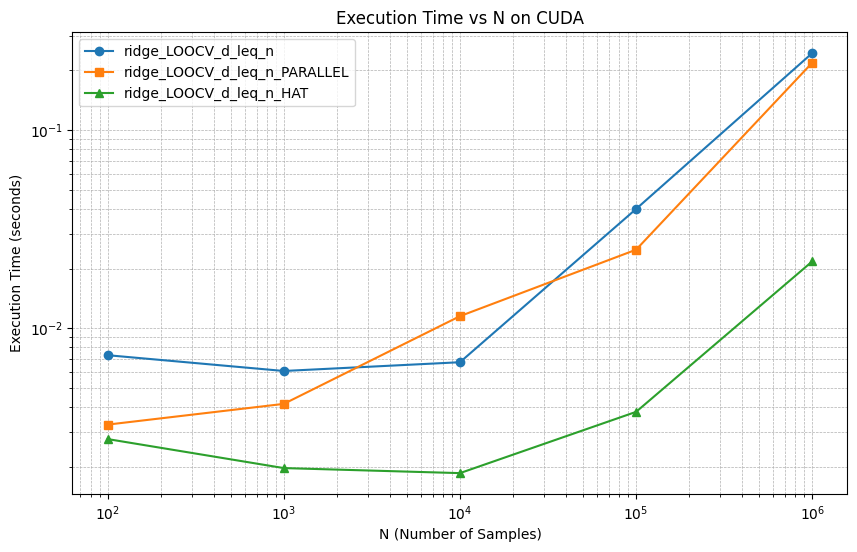

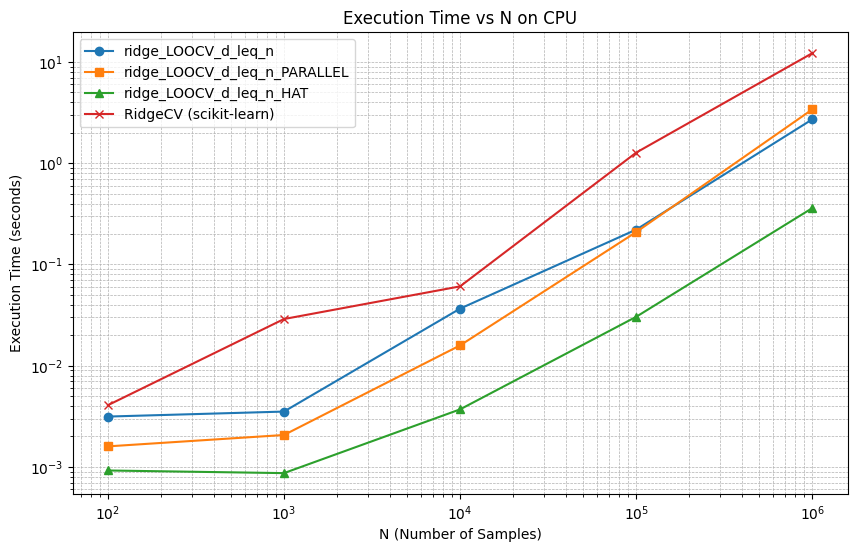

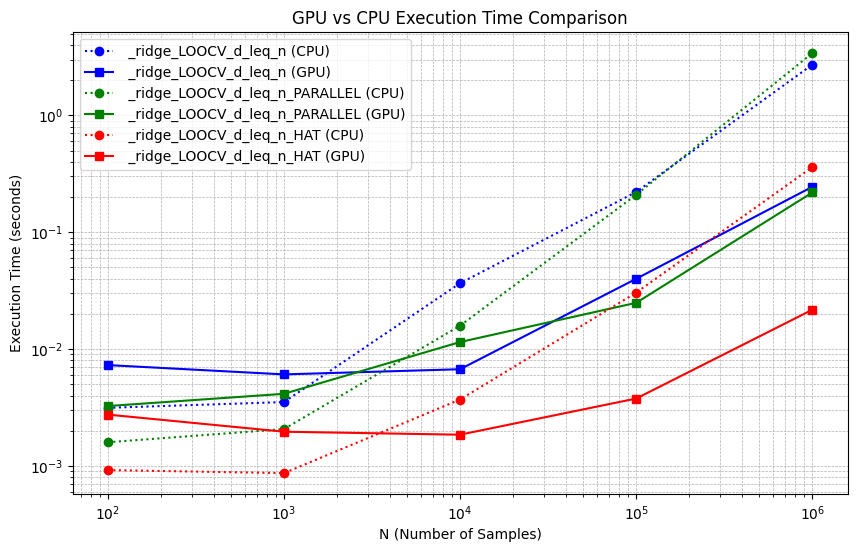

In [26]:
import matplotlib.pyplot as plt

# Plot the results
for device in execution_times.keys():
    plt.figure(figsize=(10, 6))
    N_values = execution_times[device]['N_values']
    plt.plot(N_values, execution_times[device]['_ridge_LOOCV_d_leq_n'], marker='o', label='ridge_LOOCV_d_leq_n')
    plt.plot(N_values, execution_times[device]['_ridge_LOOCV_d_leq_n_PARALLEL'], marker='s', label='ridge_LOOCV_d_leq_n_PARALLEL')
    plt.plot(N_values, execution_times[device]['_ridge_LOOCV_d_leq_n_HAT'], marker='^', label='ridge_LOOCV_d_leq_n_HAT')
    if device == 'cpu':
        plt.plot(N_values, execution_times[device]['RidgeCV'], marker='x', label='RidgeCV (scikit-learn)')

    plt.xlabel('N (Number of Samples)')
    plt.ylabel('Execution Time (seconds)')
    plt.title(f'Execution Time vs N on {device.upper()}')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.show()

# Plot GPU vs CPU processing times with same color but different line styles
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r']  # Define a list of colors for different methods
for idx, method in enumerate(['_ridge_LOOCV_d_leq_n', '_ridge_LOOCV_d_leq_n_PARALLEL', '_ridge_LOOCV_d_leq_n_HAT']):
    plt.plot(execution_times['cpu']['N_values'], execution_times['cpu'][method], marker='o', linestyle='dotted', color=colors[idx], label=f' {method} (CPU)')
    plt.plot(execution_times['cuda']['N_values'], execution_times['cuda'][method], marker='s', linestyle='solid', color=colors[idx], label=f' {method} (GPU)')

plt.xlabel('N (Number of Samples)')
plt.ylabel('Execution Time (seconds)')
plt.title('GPU vs CPU Execution Time Comparison')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

In [27]:
# Ensure that all 4 methods coincide
print("Comparing coefficients and intercepts from different methods:")

# Compare coefficients
print("Max difference in coefficients between _ridge_LOOCV_d_leq_n and _ridge_LOOCV_d_leq_n_PARALLEL:", torch.max(torch.abs(beta_opt - beta_opt_par)))
print("Max difference in coefficients between _ridge_LOOCV_d_leq_n and _ridge_LOOCV_d_leq_n_HAT:", torch.max(torch.abs(beta_opt - beta_opt_hat)))
print("Max difference in coefficients between _ridge_LOOCV_d_leq_n and sklearn RidgeCV:", torch.max(torch.abs(beta_opt - beta_sklearn.T)))
print("\n")

# Compare intercepts
print("Difference in intercept between _ridge_LOOCV_d_leq_n and sklearn RidgeCV:", torch.abs(intercept - model.intercept_))
print("Difference in intercept between _ridge_LOOCV_d_leq_n_PARALLEL and sklearn RidgeCV:", torch.abs(intercept - model.intercept_))
print("Difference in intercept between _ridge_LOOCV_d_leq_n_HAT and sklearn RidgeCV:", torch.abs(intercept - model.intercept_))

Comparing coefficients and intercepts from different methods:
Max difference in coefficients between _ridge_LOOCV_d_leq_n and _ridge_LOOCV_d_leq_n_PARALLEL: tensor(0.)
Max difference in coefficients between _ridge_LOOCV_d_leq_n and _ridge_LOOCV_d_leq_n_HAT: tensor(4.2259e-08)
Max difference in coefficients between _ridge_LOOCV_d_leq_n and sklearn RidgeCV: tensor(3.7227e-06)


Difference in intercept between _ridge_LOOCV_d_leq_n and sklearn RidgeCV: tensor([2.2735e-10], dtype=torch.float64)
Difference in intercept between _ridge_LOOCV_d_leq_n_PARALLEL and sklearn RidgeCV: tensor([2.2735e-10], dtype=torch.float64)
Difference in intercept between _ridge_LOOCV_d_leq_n_HAT and sklearn RidgeCV: tensor([2.2735e-10], dtype=torch.float64)


In [31]:
from ridge_ALOOCV import fit_ridge_ALOOCV

def test_vs_sklearn():
    # Test fit_ridge_ALOOCV vs sklearn
    N = 1000
    D = 50
    p = 10
    X = torch.randn(N, D)
    y = torch.randn(N, p)
    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

    model = RidgeCV(alphas=alphas)
    model.fit(X, y)
    y_pred_sk = model.predict(X)
    error_sk = ((y_pred_sk - y.numpy()) ** 2).mean()
    print("sklearn")
    print(model.alpha_, "model.alpha_")
    print(model.coef_, "model.coef_")
    print(model.intercept_, "model.intercept_")
    print(y_pred_sk, "y_pred")
    print(error_sk, "error")
    print("\n")

    beta_aloocv, intercept_aloocv, alpha_aloocv = fit_ridge_ALOOCV(X, y, alphas=alphas)
    y_pred_aloocv = X @ beta_aloocv + intercept_aloocv
    error_aloocv = ((y - y_pred_aloocv) ** 2).mean().item()
    print("ALOOCV torch")
    print(alpha_aloocv, "alpha")
    print(beta_aloocv, "beta")
    print(intercept_aloocv, "intercept")
    print(y_pred_aloocv, "y_pred")
    print(error_aloocv, "error")
    print("\n")

    # Differences
    print("differences")
    print(model.alpha_ - alpha_aloocv, "alpha diff")
    print(model.coef_.T - beta_aloocv.cpu().numpy(), "beta diff")
    print(model.intercept_ - intercept_aloocv.cpu().numpy(), "intercept diff")
    print(y_pred_sk - y_pred_aloocv.cpu().numpy(), "y_pred diff")
    print(error_sk - error_aloocv, "error diff")

test_vs_sklearn()

sklearn
1000.0 model.alpha_
[[ 0.015 -0.018 -0.003 ... -0.017 -0.008 -0.04 ]
 [ 0.001  0.014  0.02  ... -0.006  0.029  0.011]
 [-0.045 -0.008  0.006 ... -0.014 -0.003 -0.002]
 ...
 [-0.001 -0.02   0.026 ...  0.027 -0.018 -0.007]
 [-0.007 -0.011 -0.004 ... -0.027  0.021  0.006]
 [-0.005  0.01   0.007 ... -0.018  0.023 -0.023]] model.coef_
[-0.029  0.003  0.007 ...  0.019 -0.025 -0.039] model.intercept_
[[-0.139  0.168  0.004 ... -0.159 -0.051 -0.097]
 [ 0.01   0.17  -0.062 ...  0.06  -0.075  0.036]
 [-0.094 -0.08  -0.141 ...  0.176 -0.038  0.01 ]
 ...
 [ 0.09  -0.001  0.012 ... -0.073  0.03  -0.068]
 [-0.089  0.088 -0.119 ... -0.125  0.107  0.01 ]
 [-0.018  0.204 -0.141 ...  0.13  -0.143 -0.029]] y_pred
0.9906888955729988 error


ALOOCV torch
1000.0 alpha
tensor([[ 0.0145,  0.0014, -0.0447, -0.0057, -0.0006, -0.0045, -0.0028, -0.0009,
         -0.0073, -0.0047],
        [-0.0181,  0.0142, -0.0080, -0.0345, -0.0198, -0.0098, -0.0262, -0.0201,
         -0.0109,  0.0095],
        [-0.0034,